

# <center>STAT 689 Final Project </center>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

BASE_URL = "https://raw.githubusercontent.com/jeffRauenbuehler/tamu/main/689_final_project/data/"
STANDARD_METHOD_URL = BASE_URL + "standard_method.csv"

In [21]:
df = pd.read_csv(STANDARD_METHOD_URL)

In [22]:
def get_top_features(df: pd.DataFrame, n: int = 5) -> list:
    """Get the top n features using f_regression

    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with features
    n: int
        Number of features you want returned
        (Optional) Defaults to: 5

    Returns
    ----------
    list
        Top n features
    """
    X = df.iloc[:, 0:29]
    Y = df["state"]
    top_features = SelectKBest(score_func=f_regression, k="all")
    fit = top_features.fit(X, Y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X.columns)
    features_scores = pd.concat([df_columns, df_scores], axis=1)
    features_scores.columns = ["features", "fcore"]
    features = (
        features_scores.sort_values(by="fcore", ascending=False)
        .reset_index(drop=True)
    )
    top_features_ls = features["features"].head(n).to_list()
    return top_features_ls

In [23]:
def get_train_test_split(
    df, features=[], train_size=0.60, test_size=0.40, target="state"
) -> pd.DataFrame:
    """Trains a logistic machine learning model for a dataframe

    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with features to use for model training

    Returns
    ----------
    x_train: pd.DataFrame
    x_test: pd.DataFrame
    y_train: pd.Series
    y_test: pd.Series
    """
    if features:
        X = df[features]
    else:
        X = df.iloc[:, 0:29]
    y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size, random_state=1
    )
    return x_train, x_test, y_train, y_test

In [24]:
def train_logistic_model(df: pd.DataFrame, features: list = [], max_iter=1000):
    """Trains a logistic machine learning model for a dataframe

    Parameters
    ----------
    df: pd.DataFrame
        Dataframe with features to train model on

    Returns
    ----------
    model: sklearn.linear_model._logistic.LogisticRegression
        Trained Logistic model
    y_test: pandas.Series
        Test portion for the Target of the train_test_split
    y_pred: numpy.ndarray
        Prediction vector from the model
    """
    x_train, x_test, y_train, y_test = get_train_test_split(df, features)
    model = LogisticRegression(max_iter=max_iter)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return model, y_test, y_pred

In [25]:
def train_knn_model(df: pd.DataFrame, features: list = []):
    """_summary_

    Parameters
    ----------
    df: pd.DataFrame
        _description_
    features: list
        _description_
        (Optional) Defaults to: []

    Returns
    ----------
    knn_model: sklearn.KNeighborsClassifier
        Trained Nearest Neighbors model
    y_test: pd.Series
        Test data for target
    y_pred: np.ndarray
        Predictions for target
    """
    x_train, x_test, y_train, y_test = get_train_test_split(df, features)
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_test)

    return knn_model, y_test, y_pred

In [26]:
def create_roc_curve(models) -> bool:
    """Create an ROC curve from an input of test and prediction data

    Parameters
    ----------
    label1: str
        Model type of the first element
    y_test1: pd.Series
        Test data from model training for the first model
    y_pred1: np.array
        Prediction data from model training for the first model

    Returns
    ----------
    bool
    """
    plt.figure(0).clf()
    fig, axs = plt.subplots(figsize=(18, 12))
    for model in models:
        fpr, tpr, _ = metrics.roc_curve(model["y_test"], model["y_pred"])
        roc_auc = metrics.auc(fpr, tpr)
        label = model["label"]
        plt.plot(fpr, tpr, label=f"{label}, auc={roc_auc}")
    plt.legend(loc=0)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    return True

In [27]:
def get_specificity_sensitivity(y_test: pd.Series, y_pred: np.array):
    """Get the specificity and sensitivity from a confusion matrix

    Parameters
    ----------
    y_test: pd.Series
        Test data from model training
    y_pred: np.array
        Prediction data from model training

    Returns
    ----------
    sensitivity: float
        Sensitivity calculated using the confusion matrix
    specificity: float
        Specificity calculated using the confusion matrix
    """
    cm = metrics.confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

In [28]:
def create_data_df(
    dataset: str,
    model_type: str,
    sensitivity: float,
    specificity: float,
    accuracy: float,
    precision: float,
) -> pd.DataFrame:
    """Create dataframe of data from inputs

    Parameters
    ----------
    dataset: str
        The dataset the data is from "standard method" or "distance method"
    model_type: str
        The model that was used to get the results
    sensitivity: float
    specificity: float
    accuracy: float
    precision: float

    Returns
    ----------
    pd.DataFrame
    """
    data = pd.DataFrame(
        {
            "dataset": dataset,
            "model_type": model_type,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "accuracy": accuracy,
            "precision": precision,
        },
        index=[0],
    )

    return data

In [29]:
def get_output(df: pd.DataFrame, dataset: str, model_type: str, n: int = 14):
    """ Get output of model training
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to train model on
    dataset: str
        Dataset the model comes from (standard method or distance variance)
    model_type: str
        logistic or knn
    n: int
        Number of features to use (selects top n)
        (Optional) Defaults to: 10
    
    Returns
    ----------
    data: pd.DataFrame
    y_test: pd.Series
        Test data from model training
    y_pred: np.array
        Prediction data from model training
    classification_report
    """
    top_features_ls = get_top_features(df, n)
    if model_type.upper() == "KNN":
        model, y_test, y_pred = train_knn_model(df, top_features_ls)
    elif model_type.upper() == "LOGISTIC":
        model, y_test, y_pred = train_logistic_model(df, top_features_ls)
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred, zero_division=1)
    classification_report = metrics.classification_report(
        y_test, y_pred, zero_division=1
    )
    sensitivity, specificity = get_specificity_sensitivity(y_test, y_pred)
    data = create_data_df(
        dataset,
        model_type.upper(),
        sensitivity,
        specificity,
        accuracy_score,
        precision_score,
    )
    return model, data, y_test, y_pred, classification_report

## Standard Method

In [30]:
models_ls = []
# Logistic Model
model_lm, data_lm, y_test_lm, y_pred_lm, classification_report_lm = get_output(
    df, "standard method", "LOGISTIC"
)
models_ls.append({"label":"Logistic - Standard Method",
        "y_test": y_test_lm,
        "y_pred": y_pred_lm,
        })
# KNN model
model_knn, data_knn, y_test_knn, y_pred_knn, classification_report_knn = get_output(
    df, "standard method", "knn"
)
models_ls.append(
        {"label":"KNN - Standard Method",
        "y_test": y_test_knn,
        "y_pred": y_pred_knn,
        }
        )

True

<Figure size 432x288 with 0 Axes>

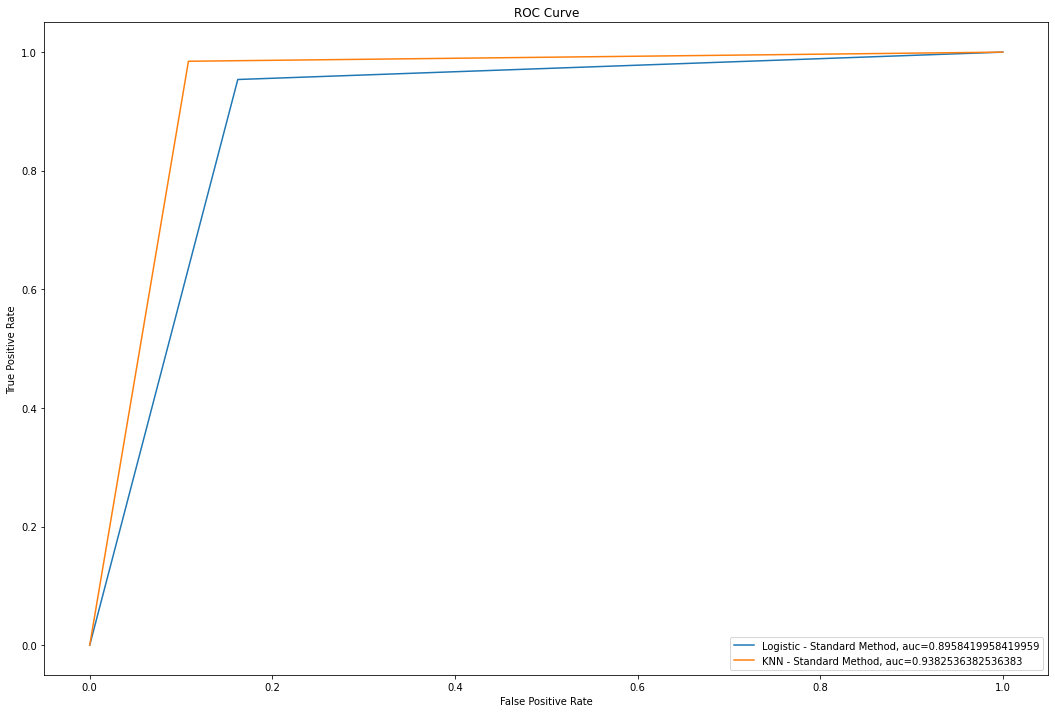

In [31]:
create_roc_curve(models_ls)

In [32]:
model_comparisons = pd.concat(
    [data_lm, data_knn],
    ignore_index=True,
)
model_comparisons

,dataset,model_type,sensitivity,specificity,accuracy,precision
0,standard method,LOGISTIC,0.953846,0.837838,0.911765,0.911765
1,standard method,KNN,0.984615,0.891892,0.950980,0.941176


### Random Exploration Code

<AxesSubplot:>

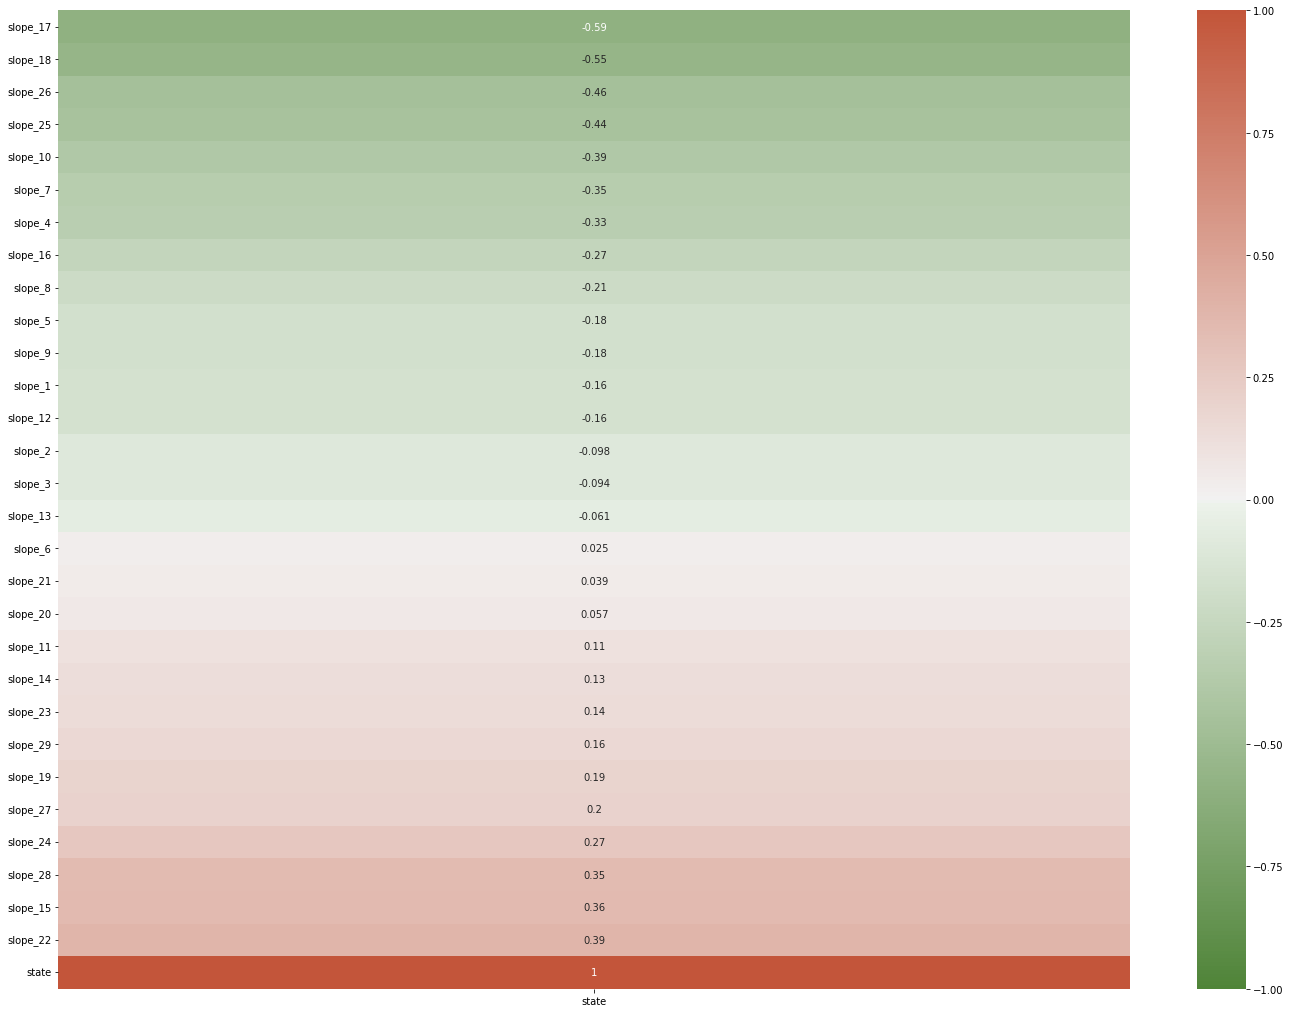

In [33]:
# Investigate correlation of features with target to verify that we only using the ones that correlate strongest with the target (either positively or negatively)
top_n_features = get_top_features(df)
top_n_features.append("state")
corr = df[top_n_features].corr()
fig, axs = plt.subplots(figsize=(24, 18))
cmap = sns.diverging_palette(120, 20, as_cmap=True)
#sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap, annot=True)
sns.heatmap(df.corr()[["state"]].sort_values("state"),
 vmax=1, vmin=-1, cmap=cmap, annot=True)

C:\Users\jeffr\AppData\Local\Temp/ipykernel_16132/497882727.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'slope_1'}>,
        <AxesSubplot:title={'center':'slope_2'}>,
        <AxesSubplot:title={'center':'slope_3'}>,
        <AxesSubplot:title={'center':'slope_4'}>,
        <AxesSubplot:title={'center':'slope_5'}>],
       [<AxesSubplot:title={'center':'slope_6'}>,
        <AxesSubplot:title={'center':'slope_7'}>,
        <AxesSubplot:title={'center':'slope_8'}>,
        <AxesSubplot:title={'center':'slope_9'}>,
        <AxesSubplot:title={'center':'slope_10'}>],
       [<AxesSubplot:title={'center':'slope_11'}>,
        <AxesSubplot:title={'center':'slope_12'}>,
        <AxesSubplot:title={'center':'slope_13'}>,
        <AxesSubplot:title={'center':'slope_14'}>,
        <AxesSubplot:title={'center':'slope_15'}>],
       [<AxesSubplot:title={'center':'slope_16'}>,
        <AxesSubplot:title={'center':'slope_17'}>,
        <AxesSubplot:title={'center':'slope_18'}>,
        <AxesSubplot:title={'center':'slope_19'}>,
        <AxesSubplot:title={'center':

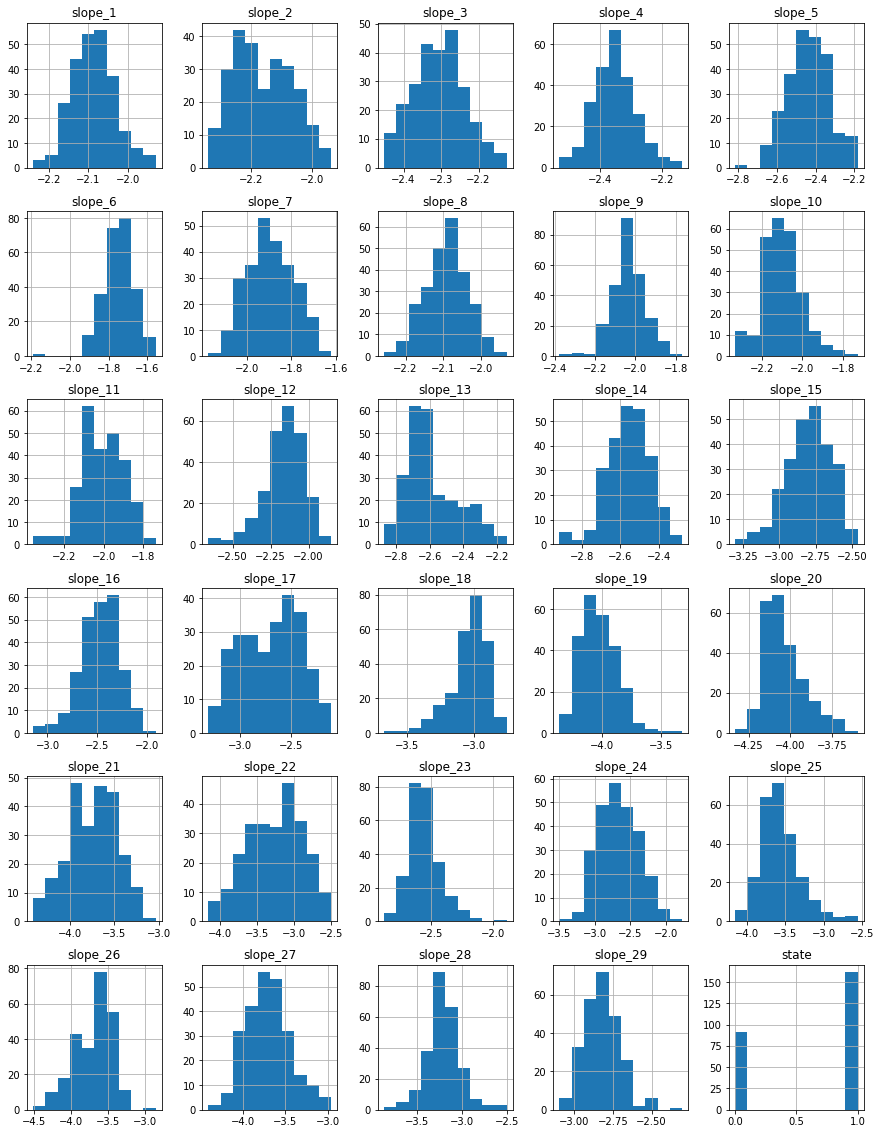

In [34]:
# Look at distributions of features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

In [35]:
# Look into outliers
q1=df.quantile(0.25)
q3=df.quantile(0.75)
IQR=q3-q1
outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
outliers = outliers.dropna(axis = 0, how = 'all')
outliers = pd.DataFrame(outliers.count())
#outliers
outliers[0].sum()

118

In [36]:
# Test for Overfitting. If accuracy score is significantly lower than model then we were overfitting
x_train, x_test, y_train, y_test = get_train_test_split(df, get_top_features(df, 14))
score = model_lm.score(x_test, y_test)
print("Accuracy: ", score)

Accuracy:  0.9117647058823529


In [37]:
x_train, x_test, y_train, y_test = get_train_test_split(df, get_top_features(df, 14))
score = model_knn.score(x_test, y_test)
print("Accuracy: ", score)

Accuracy:  0.6372549019607843


c:\Users\jeffr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
